In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.chdir('../')

In [2]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [201]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
from collections import Counter 
from sklearn.decomposition import PCA


In [7]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [8]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [9]:
dataset = 'dsprites_20'
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'

In [10]:
dataset_name = dataset
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/dsprites_20/preprocessed/'

In [11]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = '../cem/cem/dsprites/preprocessed/extra.pkl'

In [12]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [13]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)
extra_loader = load_data([extra_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [14]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/dsprites_20/joint_model_small3/joint/best_model_42.pth


## Plot the Dataset

In [15]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))
extra_pkl = pickle.load(open(extra_data_path,"rb"))

In [16]:
len(train_pkl)

5000

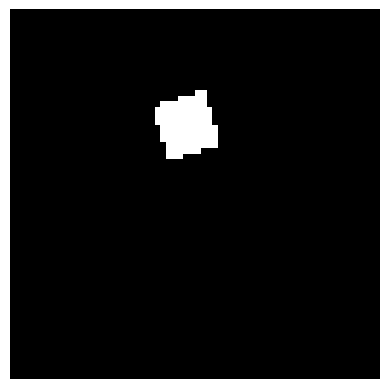

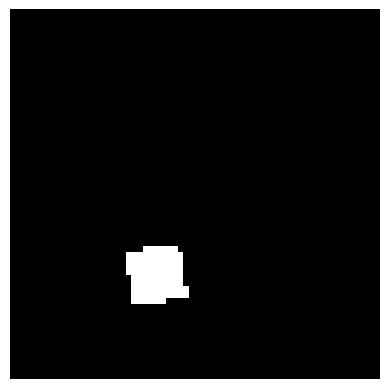

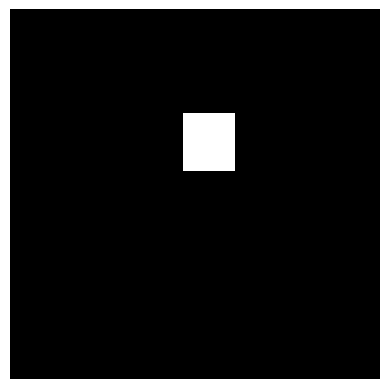

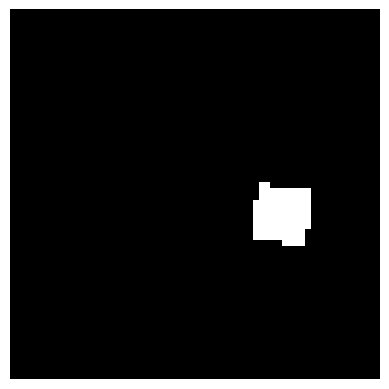

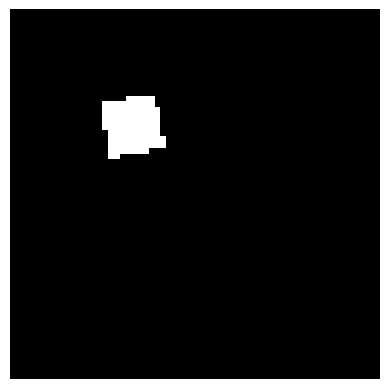

In [17]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+extra_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 

In [18]:
extra_images, extra_y, extra_c = unroll_data(extra_loader)

In [18]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

KeyboardInterrupt: 

In [230]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Run Model over all Concept Combinations

In [19]:
_, extra_predictions = run_joint_model(joint_model,extra_images)

In [20]:
extra_images.shape

torch.Size([288, 3, 299, 299])

In [21]:
extra_predictions = extra_predictions.T

In [22]:
extra_predictions = torch.nn.Sigmoid()(extra_predictions)

In [23]:
attributes_as_matrix = np.array([i['attribute_label'] for i in extra_pkl])

In [24]:
concept_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

In [25]:
results = {}
num_concepts = extra_predictions.shape[1]
for i in range(num_concepts):
    data_points_with_concept = np.where(attributes_as_matrix[:, i] == 1)[0]
    data_points_without_concept = np.where(attributes_as_matrix[:, i] == 0)[0]

    min_with_concept = torch.min(extra_predictions[data_points_with_concept,i]).item()
    max_with_concept = torch.max(extra_predictions[data_points_with_concept,i]).item()
    argmin_with_concept = data_points_with_concept[torch.argmin(extra_predictions[data_points_with_concept,i]).item()].item()
    argmax_with_concept = data_points_with_concept[torch.argmax(extra_predictions[data_points_with_concept,i]).item()].item()
    freq_with_concept_adversarial = (len([p for p in data_points_with_concept if extra_predictions[p, i] < 0.75]),len(data_points_with_concept))

    if len(data_points_without_concept) == 0:
        min_without_concept = -1
        max_without_concept = -1

        argmin_without_concept = -1
        argmax_without_concept = -1
    else:
        min_without_concept = torch.min(extra_predictions[data_points_without_concept,i]).item()
        max_without_concept = torch.max(extra_predictions[data_points_without_concept,i]).item()

        argmin_without_concept = data_points_without_concept[torch.argmin(extra_predictions[data_points_without_concept,i]).item()].item()
        argmax_without_concept = data_points_without_concept[torch.argmax(extra_predictions[data_points_without_concept,i]).item()].item()

    results[concept_names[i]] = {
        'min_with_concept': min_with_concept, 
        'max_with_concept': max_with_concept, 
        'min_without_concept': min_without_concept, 
        'max_without_concept': max_without_concept,
        'freq_with_concept_adversarial': freq_with_concept_adversarial,
        'argmin_with_concept': argmin_with_concept, 
        'argmax_with_concept': argmax_with_concept, 
        'argmin_without_concept': argmin_without_concept, 
        'argmax_without_concept': argmax_without_concept,
    }

In [26]:
total_adversarial = np.sum([results[i]['freq_with_concept_adversarial'][0] for i in results])/np.sum([results[i]['freq_with_concept_adversarial'][1] for i in results])
total_adversarial

0.3420138888888889

In [27]:
results 

{'is_white': {'min_with_concept': 0.9999996423721313,
  'max_with_concept': 1.0,
  'min_without_concept': -1,
  'max_without_concept': -1,
  'freq_with_concept_adversarial': (0, 288),
  'argmin_with_concept': 16,
  'argmax_with_concept': 0,
  'argmin_without_concept': -1,
  'argmax_without_concept': -1},
 'is_square': {'min_with_concept': 7.787506757926402e-30,
  'max_with_concept': 1.0,
  'min_without_concept': 9.193536845169927e-25,
  'max_without_concept': 1.0,
  'freq_with_concept_adversarial': (63, 96),
  'argmin_with_concept': 92,
  'argmax_with_concept': 50,
  'argmin_without_concept': 123,
  'argmax_without_concept': 162},
 'is_ellipse': {'min_with_concept': 1.1302188915400275e-27,
  'max_with_concept': 1.0,
  'min_without_concept': 1.0347224225380763e-24,
  'max_without_concept': 1.0,
  'freq_with_concept_adversarial': (55, 96),
  'argmin_with_concept': 183,
  'argmax_with_concept': 102,
  'argmin_without_concept': 90,
  'argmax_without_concept': 2},
 'is_heart': {'min_with_co

In [266]:
json.dump(results,open('results/dsprites/adversarial_with_rotation.json','w'))

## Dataset Exploration

In [29]:
def list_to_string(l):
    return ''.join([str(i) for i in l])

In [30]:
def string_to_concepts(s):
    return [concept_names[j] for j in range(len(concept_names)) if s[j] == '1']

In [31]:
list_to_index = {}
for i in range(len(extra_pkl)):
    list_to_index[list_to_string(extra_pkl[i]['attribute_label'])] = i

In [32]:
present_concept_combo = list(set([list_to_string(i['attribute_label']) for i in train_pkl]))

In [149]:
concept_of_interest = 'is_heart'
concept_idx = concept_names.index(concept_of_interest)
argmin_with_concept = results[concept_of_interest]['argmin_with_concept']
argmax_with_concept = results[concept_of_interest]['argmax_with_concept']

In [150]:
results[concept_of_interest]['freq_with_concept_adversarial'][0]/results[concept_of_interest]['freq_with_concept_adversarial'][1]

0.3541666666666667

In [136]:
all_predictions = [list_to_string([int(i) for i in np.round(j.detach().numpy())]) for j in extra_predictions]
num_predicted_not_seen = len([i for i in all_predictions if i not in present_concept_combo])/len(all_predictions)
num_predicted_not_seen

0.71875

In [137]:
num_predicted_not_subset = []

for i in all_predictions:
    for j in present_concept_combo: 
        for k in range(len(i)):
            if i[k] == '1' and j[k] == '0':
                break 
        else:
            num_predicted_not_subset.append(i)
len(num_predicted_not_subset)/len(all_predictions)

0.5694444444444444

In [138]:
num_predicted_not_subset = []

for i in all_predictions:
    close_match = False 
    min_distance = 10000
    for j in present_concept_combo: 
        curr_distance = 0
        for k in range(len(i)):
            if i[k] == '1' and j[k] == '0':
                curr_distance += 1
        min_distance = min(min_distance,curr_distance)
    if min_distance > 0: 
        num_predicted_not_subset.append(i)
len(num_predicted_not_subset)/len(all_predictions)

0.5243055555555556

8.937600659564282e-12


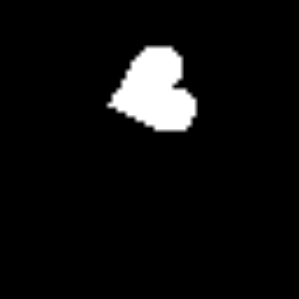

In [139]:
print(extra_predictions[argmin_with_concept][concept_idx].item())
numpy_to_pil(extra_images[argmin_with_concept].detach().numpy())

1.0


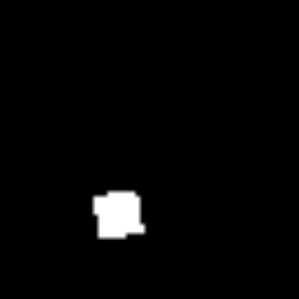

In [140]:
print(extra_predictions[argmax_with_concept][concept_idx].item())
numpy_to_pil(extra_images[argmax_with_concept].detach().numpy())

In [141]:
combo_with_concept = [i for i in present_concept_combo if i[concept_idx] == '1']
for i in combo_with_concept:
    print([concept_names[j] for j in range(len(concept_names)) if i[j] == '1'])
combo_with_concept

['is_white', 'is_ellipse', 'is_scale_1', 'is_orientation_180', 'is_x_0', 'is_y_16']
['is_white', 'is_ellipse', 'is_scale_0.9', 'is_orientation_0', 'is_x_0', 'is_y_16']
['is_white', 'is_square', 'is_scale_0.9', 'is_orientation_270', 'is_x_0', 'is_y_16']
['is_white', 'is_ellipse', 'is_scale_1', 'is_orientation_90', 'is_x_0', 'is_y_0']
['is_white', 'is_square', 'is_scale_0.8', 'is_orientation_90', 'is_x_0', 'is_y_16']
['is_white', 'is_heart', 'is_scale_1', 'is_orientation_0', 'is_x_0', 'is_y_16']
['is_white', 'is_heart', 'is_scale_0.7', 'is_orientation_180', 'is_x_0', 'is_y_0']
['is_white', 'is_square', 'is_scale_1', 'is_orientation_0', 'is_x_0', 'is_y_16']


['101000000100101001',
 '101000001010001001',
 '110000001000011001',
 '101000000101001010',
 '110000010001001001',
 '100100000110001001',
 '100100100000101010',
 '110000000110001001']

In [142]:
all_with_1 = []
for i in list_to_index:
    if i[concept_idx] == '1':
        distances = [hamming_distance(i,j) for j in combo_with_concept]
        idx = np.argmin(distances)
        min_dist = distances[idx] 
        flipped_concepts = hamming_distance(i,combo_with_concept[idx],diff_names=concept_names,ret_diff=True)
        idx = list_to_index[i] 
        pred = extra_predictions[idx,concept_idx]
        all_with_1.append({'dist': min_dist, 'name': i, 'prediction': pred.item(), 'differences': flipped_concepts[1]})
predictions = [i['prediction'] for i in all_with_1]

In [143]:
list_flatten_1 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] >= 0.75]))
list_flatten_0 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] < 0.75]))

In [144]:
counter_1 = Counter(list_flatten_1)
counter_0 = Counter(list_flatten_0) 

for i in counter_1:
    counter_1[i] /= len(list_flatten_1)
    counter_1[i] = round(counter_1[i],2)

    if i not in counter_0:
        counter_0[i] = 0.0

for i in counter_0:
    counter_0[i] /= len(list_flatten_0)
    counter_0[i] = round(counter_0[i],2)

    if i not in counter_1:
        counter_1[i] = 0.0

counter_0 = dict(counter_0)
counter_1 = dict(counter_1)

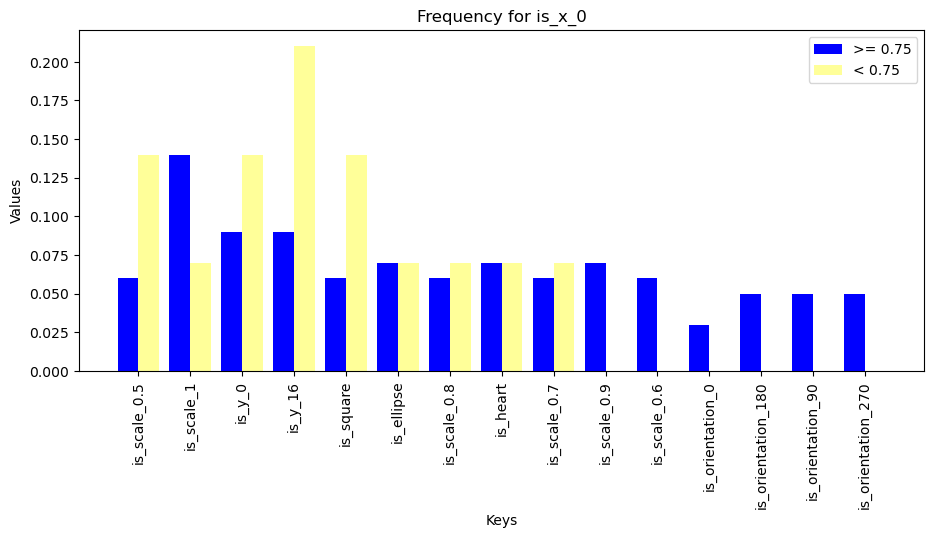

In [145]:
keys = list(counter_1.keys())
values_1 = list(counter_1.values())
values_0 = list(counter_0.values())

width = 0.4  # Width of the bars
x = np.arange(len(keys))  # Numeric locations for the bars

plt.bar(x - width/2, values_1, width, color='blue', label='>= 0.75')
plt.bar(x + width/2, values_0, width, color='#FFFF99', label='< 0.75')  # Light yellow

plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Frequency for {}'.format(concept_of_interest))
plt.xticks(x, keys, rotation='vertical')  # Rotate x-axis labels vertically
plt.legend()
plt.tight_layout()  # Adjust layout for better appearance
plt.gcf().set_size_inches(10, 6)  # Adjust the width of the graph
plt.show()

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  


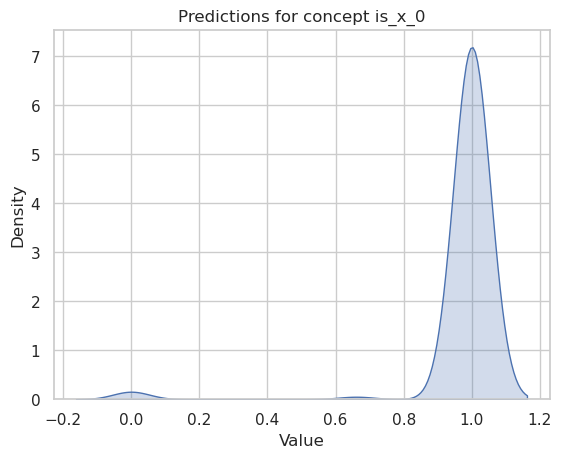

In [146]:
sns.set(style="whitegrid")  # Set the style of the plot
sns.kdeplot(predictions, shade=True)  # Create the kernel density plot
plt.xlabel("Value")  # Label for x-axis
plt.ylabel("Density")  # Label for y-axis
plt.title("Predictions for concept {}".format(concept_of_interest))  # Title of the plot
plt.show()  # Show the plot

## Patterns in Concept-Concept Combination

In [36]:
correct_answers = [list_to_string(i) for i in attributes_as_matrix]

In [44]:
overall_accuracy = len([i for i in range(len(correct_answers)) if correct_answers[i] == all_predictions[i]])/len(all_predictions)
overall_accuracy

0.03819444444444445

In [61]:
accuracy_by_distance = {}

for i in range(len(correct_answers)):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in accuracy_by_distance:
        accuracy_by_distance[min_distance] = []

    accuracy_by_distance[min_distance].append(int(all_predictions[i] == correct_answers[i]))

for i in accuracy_by_distance:
    accuracy_by_distance[i] = (np.mean(accuracy_by_distance[i]),len(accuracy_by_distance[i]))


In [62]:
accuracy_by_distance

{4: (0.0, 100), 2: (0.005952380952380952, 168), 0: (0.5, 20)}

In [79]:
accuracy_by_distance_without_orientation = {}
orientation_idx = [i for i,name in enumerate(concept_names) if 'orientation' not in name]

for i in range(len(correct_answers)):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in accuracy_by_distance_without_orientation:
        accuracy_by_distance_without_orientation[min_distance] = []

    accuracy = 1
    for j in range(len(concept_names)):
        if j not in orientation_idx and all_predictions[i][j] != correct_answers[i][j]:
            accuracy = 0
    
    accuracy_by_distance_without_orientation[min_distance].append(accuracy)

for i in accuracy_by_distance:
    accuracy_by_distance_without_orientation[i] = (np.mean(accuracy_by_distance_without_orientation[i]),len(accuracy_by_distance_without_orientation[i]))


In [80]:
accuracy_by_distance_without_orientation

{4: (0.12, 100), 2: (0.17857142857142858, 168), 0: (0.55, 20)}

In [81]:
concept_accuracy_by_distance = {}
for i in range(len(correct_answers)):
    for concept_name in concept_names:
        concept_idx = concept_names.index(concept_name)
        if concept_name not in concept_accuracy_by_distance:
            concept_accuracy_by_distance[concept_name] = {}

        distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)

        if min_distance not in concept_accuracy_by_distance[concept_name]:
            concept_accuracy_by_distance[concept_name][min_distance] = []

        concept_accuracy_by_distance[concept_name][min_distance].append(int(all_predictions[i][concept_idx] == correct_answers[i][concept_idx]))

for i in concept_accuracy_by_distance:
    for j in concept_accuracy_by_distance[i]:
        concept_accuracy_by_distance[i][j] = (np.mean(concept_accuracy_by_distance[i][j]),len(concept_accuracy_by_distance[i][j]))


In [82]:
concept_accuracy_by_distance

{'is_white': {4: (1.0, 100), 2: (1.0, 168), 0: (1.0, 20)},
 'is_square': {4: (0.58, 100), 2: (0.6845238095238095, 168), 0: (1.0, 20)},
 'is_ellipse': {4: (0.51, 100), 2: (0.6190476190476191, 168), 0: (0.9, 20)},
 'is_heart': {4: (0.42, 100), 2: (0.6428571428571429, 168), 0: (0.9, 20)},
 'is_scale_0.5': {4: (0.75, 100), 2: (0.875, 168), 0: (1.0, 20)},
 'is_scale_0.6': {4: (0.72, 100), 2: (0.8214285714285714, 168), 0: (1.0, 20)},
 'is_scale_0.7': {4: (0.49, 100), 2: (0.7321428571428571, 168), 0: (0.95, 20)},
 'is_scale_0.8': {4: (0.69, 100), 2: (0.7619047619047619, 168), 0: (0.95, 20)},
 'is_scale_0.9': {4: (0.73, 100), 2: (0.75, 168), 0: (0.85, 20)},
 'is_scale_1': {4: (0.7, 100), 2: (0.75, 168), 0: (0.95, 20)},
 'is_orientation_0': {4: (0.58, 100), 2: (0.625, 168), 0: (0.85, 20)},
 'is_orientation_90': {4: (0.59, 100),
  2: (0.5595238095238095, 168),
  0: (0.7, 20)},
 'is_orientation_180': {4: (0.51, 100),
  2: (0.6369047619047619, 168),
  0: (0.75, 20)},
 'is_orientation_270': {4: (0.

In [85]:
frequency_train_predicted = len([i for i in all_predictions if i in present_concept_combo])/len(all_predictions)
frequency_train_predicted

0.28125

In [88]:
frequency_train_concept_distance = {}
for i,pred in enumerate(all_predictions):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in frequency_train_concept_distance:
        frequency_train_concept_distance[min_distance] = []

    frequency_train_concept_distance[min_distance].append(int(pred in present_concept_combo))

for i in frequency_train_concept_distance:
    frequency_train_concept_distance[i] = (np.mean(frequency_train_concept_distance[i]),len(frequency_train_concept_distance[i]))

In [89]:
frequency_train_concept_distance

{4: (0.29, 100), 2: (0.2261904761904762, 168), 0: (0.7, 20)}

In [107]:
concept_pairs = [(1,2),(2,3),(1,3)] # Manually encode the same shape

for i,name in enumerate(concept_names):
    for j,name_2 in enumerate(concept_names):
        if name.split("_")[1] == name_2.split("_")[1] and name > name_2:
            concept_pairs.append((i,j))

In [108]:
freq_wrong_pair = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            has_pair = True
            break
    
    freq_wrong_pair.append(int(has_pair))
np.mean(freq_wrong_pair)

0.4097222222222222

In [109]:
frequency_double_pair_distance = {}
for i,pred in enumerate(all_predictions):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    has_pair = False

    for p_1,p_2 in concept_pairs:
        if pred[p_1] == pred[p_2] == '1':
            has_pair = True
            break

    if min_distance not in frequency_double_pair_distance:
        frequency_double_pair_distance[min_distance] = []

    frequency_double_pair_distance[min_distance].append(int(has_pair))

for i in frequency_double_pair_distance:
    frequency_double_pair_distance[i] = (np.mean(frequency_double_pair_distance[i]),len(frequency_double_pair_distance[i]))

In [110]:
frequency_double_pair_distance

{4: (0.47, 100), 2: (0.40476190476190477, 168), 0: (0.15, 20)}

In [111]:
double_pairs = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            double_pairs.append((concept_names[p_1],concept_names[p_2]))
double_pairs = Counter(double_pairs)

In [112]:
double_pairs

Counter({('is_scale_0.9', 'is_scale_0.8'): 18,
         ('is_scale_0.7', 'is_scale_0.6'): 7,
         ('is_ellipse', 'is_heart'): 44,
         ('is_scale_0.8', 'is_scale_0.6'): 2,
         ('is_scale_1', 'is_scale_0.5'): 1,
         ('is_scale_0.8', 'is_scale_0.7'): 4,
         ('is_scale_1', 'is_scale_0.6'): 6,
         ('is_orientation_90', 'is_orientation_0'): 21,
         ('is_orientation_90', 'is_orientation_180'): 20,
         ('is_square', 'is_heart'): 11,
         ('is_scale_1', 'is_scale_0.7'): 12,
         ('is_square', 'is_ellipse'): 1,
         ('is_orientation_90', 'is_orientation_270'): 11,
         ('is_orientation_270', 'is_orientation_0'): 5,
         ('is_orientation_180', 'is_orientation_0'): 2,
         ('is_scale_1', 'is_scale_0.8'): 1,
         ('is_orientation_270', 'is_orientation_180'): 1})

In [115]:
concept_sets = [
    ["is_square",
    "is_ellipse",
    "is_heart"],[
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",],[
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",],
    ["is_x_0",
    "is_x_16",],[
    "is_y_0",
    "is_y_16",]
] 

In [132]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            has_no_pair = True
    
    freq_no_pair.append(int(has_no_pair))
np.mean(freq_no_pair)

0.3298611111111111

In [134]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            freq_no_pair.append(s[0])
Counter(freq_no_pair)

Counter({'is_orientation_0': 49, 'is_scale_0.5': 45, 'is_square': 18})

## Concept Difficulty

In [151]:
image_similarity = np.zeros((len(extra_images),len(extra_images)))

In [156]:
for i in range(len(extra_images)):
    for j in range(len(extra_images)):
        image_similarity[i][j] = torch.norm(extra_images[i]-extra_images[j])

In [196]:
closest_pair_same_concept = {}
furthest_pair_same_concept = {}
avg_dist_same_concept = {}

for i,concept in enumerate(concept_names):
    if i == 0:
        continue

    data_points_with_concept = np.where(attributes_as_matrix[:,i] == 1)[0]
    similarities_with_point = image_similarity[:,data_points_with_concept][data_points_with_concept]

    furthest_pair_same_concept[concept] = np.max(similarities_with_point).item()

    for j in range(len(similarities_with_point)):
        similarities_with_point[j][j] = 10000

    closest_pair_same_concept[concept] = np.min(similarities_with_point).item()
    avg_dist_same_concept[concept] = np.mean(similarities_with_point).item()


In [192]:
closest_pair_same_concept

{'is_square': 22.796096801757812,
 'is_ellipse': 17.654212951660156,
 'is_heart': 19.88580894470215,
 'is_scale_0.5': 17.654212951660156,
 'is_scale_0.6': 19.88580894470215,
 'is_scale_0.7': 20.454326629638672,
 'is_scale_0.8': 24.94072723388672,
 'is_scale_0.9': 26.65511131286621,
 'is_scale_1': 28.952064514160156,
 'is_orientation_0': 20.369564056396484,
 'is_orientation_90': 22.205556869506836,
 'is_orientation_180': 18.122047424316406,
 'is_orientation_270': 23.658008575439453,
 'is_x_0': 19.58100700378418,
 'is_x_16': 17.654212951660156,
 'is_y_0': 17.654212951660156,
 'is_y_16': 19.58100700378418}

In [193]:
furthest_pair_same_concept

{'is_square': 108.06761169433594,
 'is_ellipse': 95.84168243408203,
 'is_heart': 84.14845275878906,
 'is_scale_0.5': 53.15654754638672,
 'is_scale_0.6': 66.743408203125,
 'is_scale_0.7': 74.98383331298828,
 'is_scale_0.8': 85.80974578857422,
 'is_scale_0.9': 97.77239990234375,
 'is_scale_1': 108.06761169433594,
 'is_orientation_0': 108.03456115722656,
 'is_orientation_90': 107.68029022216797,
 'is_orientation_180': 107.57093048095703,
 'is_orientation_270': 107.58056640625,
 'is_x_0': 108.03456115722656,
 'is_x_16': 107.57343292236328,
 'is_y_0': 105.539306640625,
 'is_y_16': 108.06761169433594}

In [197]:
avg_dist_same_concept

{'is_square': 177.71385263775787,
 'is_ellipse': 171.17823258414865,
 'is_heart': 163.1910446356568,
 'is_scale_0.5': 252.8029799196455,
 'is_scale_0.6': 261.35682387484445,
 'is_scale_0.7': 269.11491488913697,
 'is_scale_0.8': 277.8903046730492,
 'is_scale_0.9': 285.4327790290117,
 'is_scale_1': 292.23272340165244,
 'is_orientation_0': 205.57060219402666,
 'is_orientation_90': 205.04827030205433,
 'is_orientation_180': 205.67605988699714,
 'is_orientation_270': 205.91079832963,
 'is_x_0': 132.91292657252447,
 'is_x_16': 133.33261989572165,
 'is_y_0': 132.8486669201542,
 'is_y_16': 133.33477170213504}

In [194]:
closest_pair_diff_concept = {}

for i,concept in enumerate(concept_names):
    if i == 0:
        continue

    data_points_with_concept = np.where(attributes_as_matrix[:,i] == 1)[0]
    data_points_without_concept = np.where(attributes_as_matrix[:,i] != 1)[0]
    similarities_with_point = image_similarity[:,data_points_with_concept][data_points_without_concept]

    closest_pair_diff_concept[concept] = np.min(similarities_with_point).item()


In [195]:
closest_pair_diff_concept

{'is_square': 18.122047424316406,
 'is_ellipse': 19.58100700378418,
 'is_heart': 18.122047424316406,
 'is_scale_0.5': 18.122047424316406,
 'is_scale_0.6': 18.122047424316406,
 'is_scale_0.7': 20.375892639160156,
 'is_scale_0.8': 23.00108528137207,
 'is_scale_0.9': 23.0296688079834,
 'is_scale_1': 31.983444213867188,
 'is_orientation_0': 19.58100700378418,
 'is_orientation_90': 17.654212951660156,
 'is_orientation_180': 17.654212951660156,
 'is_orientation_270': 19.58100700378418,
 'is_x_0': 24.204727172851562,
 'is_x_16': 24.204727172851562,
 'is_y_0': 21.159135818481445,
 'is_y_16': 21.159135818481445}

In [198]:
images_as_numpy = extra_images.detach().numpy()

In [200]:
images_as_numpy.shape

(288, 3, 299, 299)

In [202]:
images_reshaped = images_as_numpy.reshape(288, -1)

In [203]:
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)


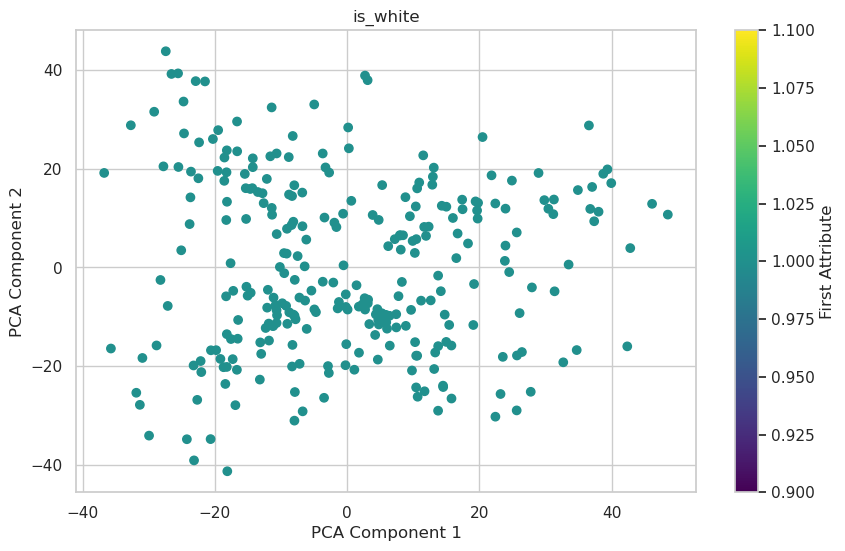

<Figure size 640x480 with 0 Axes>

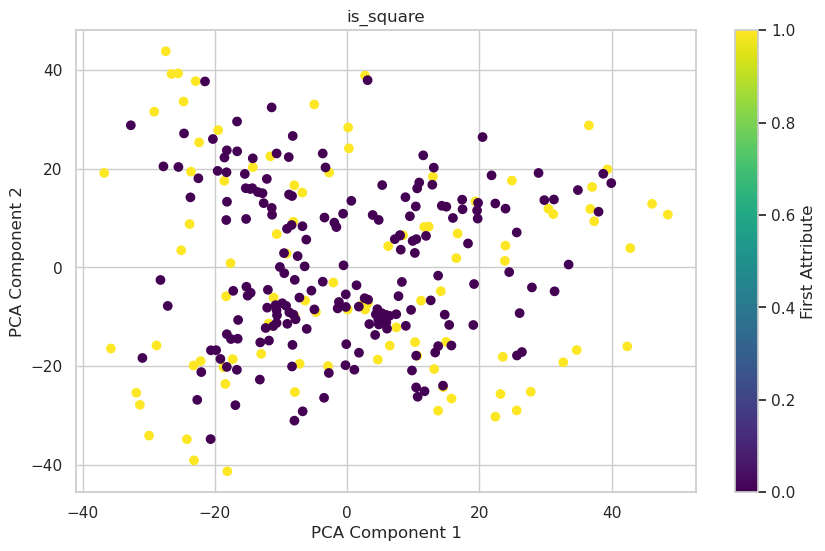

<Figure size 640x480 with 0 Axes>

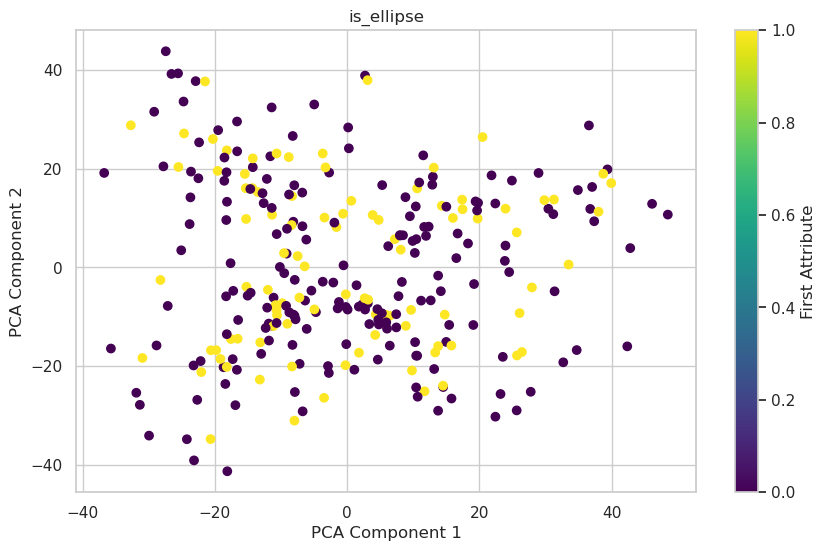

<Figure size 640x480 with 0 Axes>

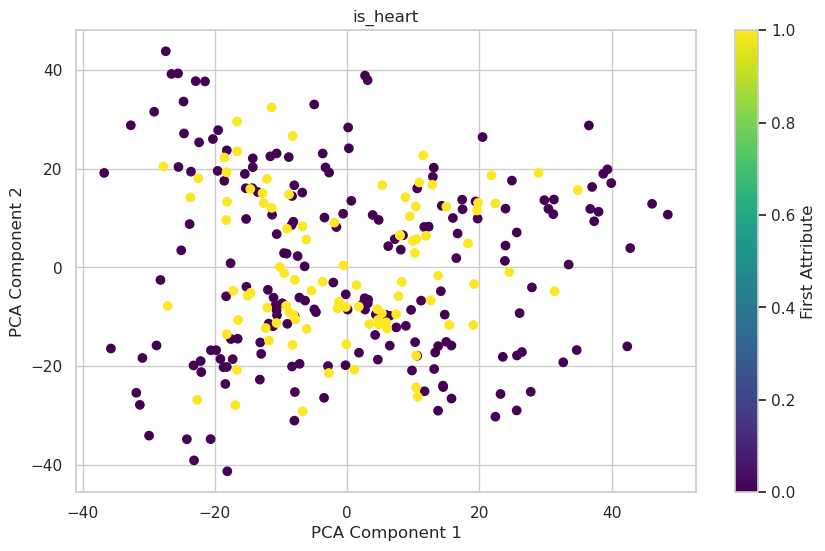

<Figure size 640x480 with 0 Axes>

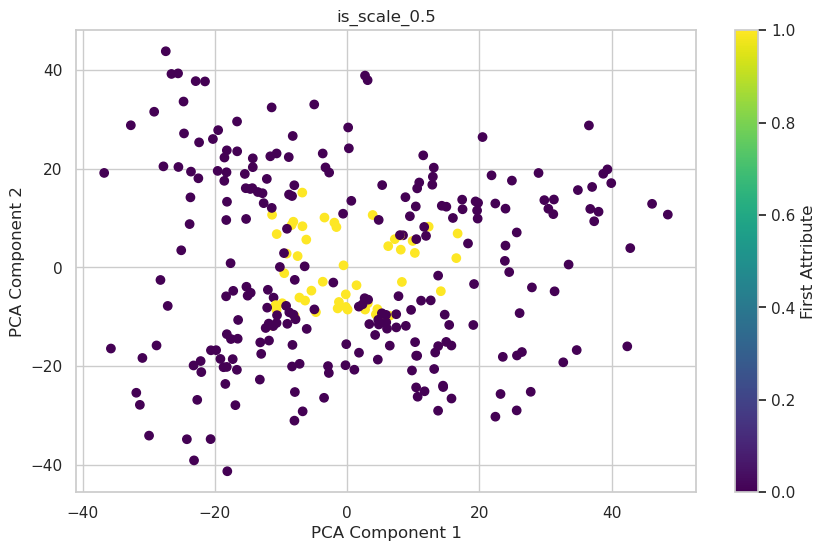

<Figure size 640x480 with 0 Axes>

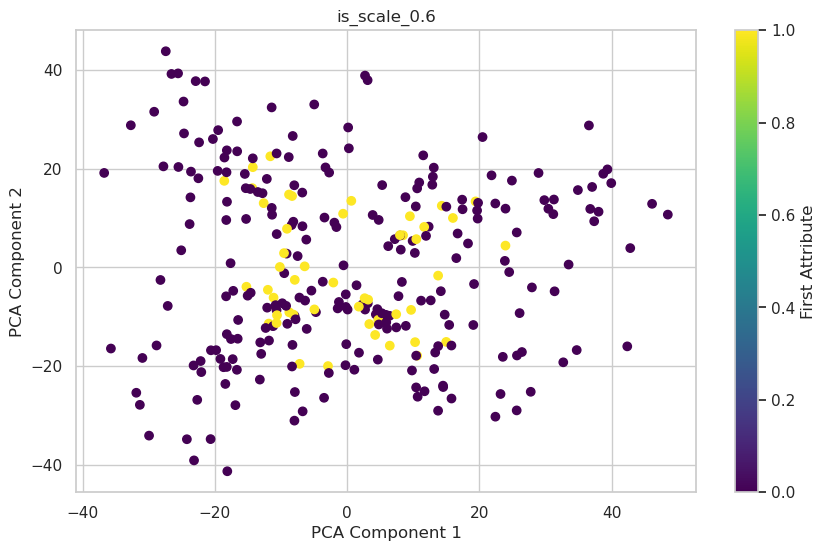

<Figure size 640x480 with 0 Axes>

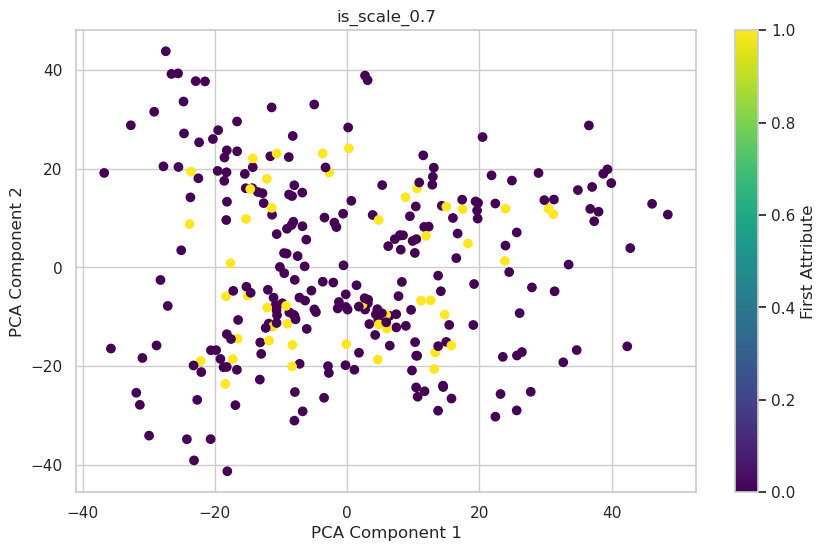

<Figure size 640x480 with 0 Axes>

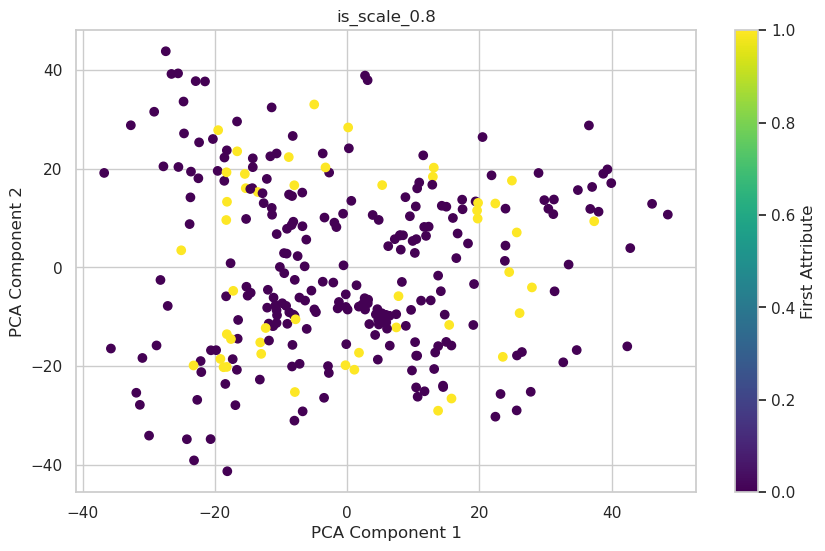

<Figure size 640x480 with 0 Axes>

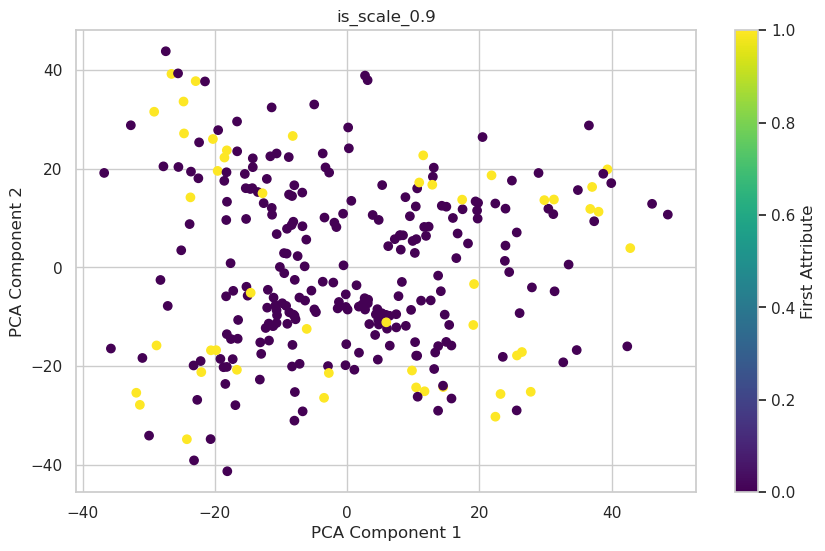

<Figure size 640x480 with 0 Axes>

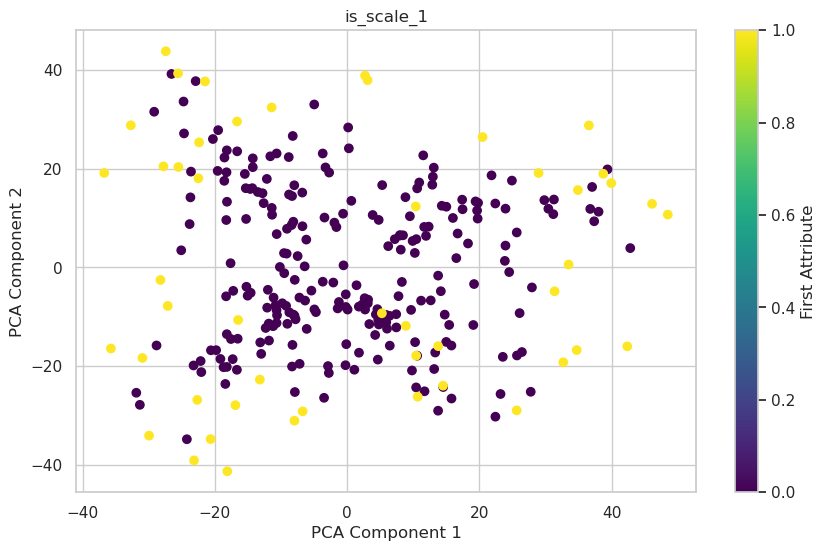

<Figure size 640x480 with 0 Axes>

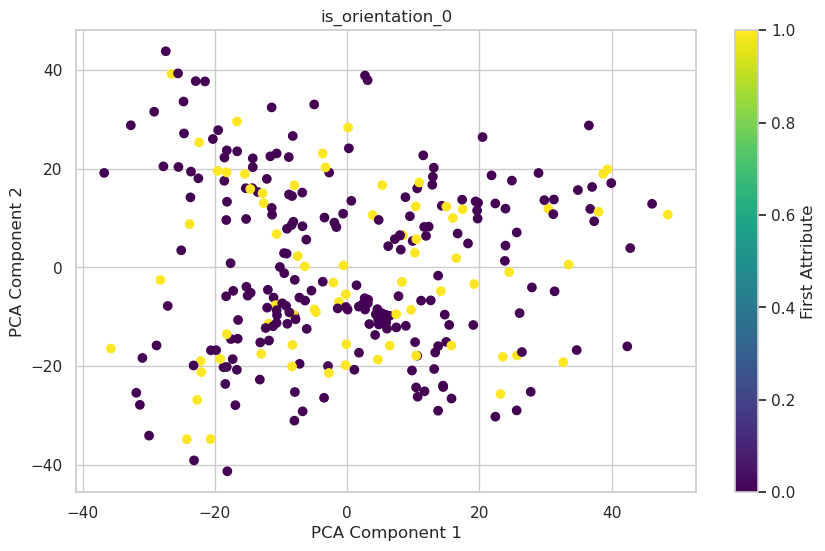

<Figure size 640x480 with 0 Axes>

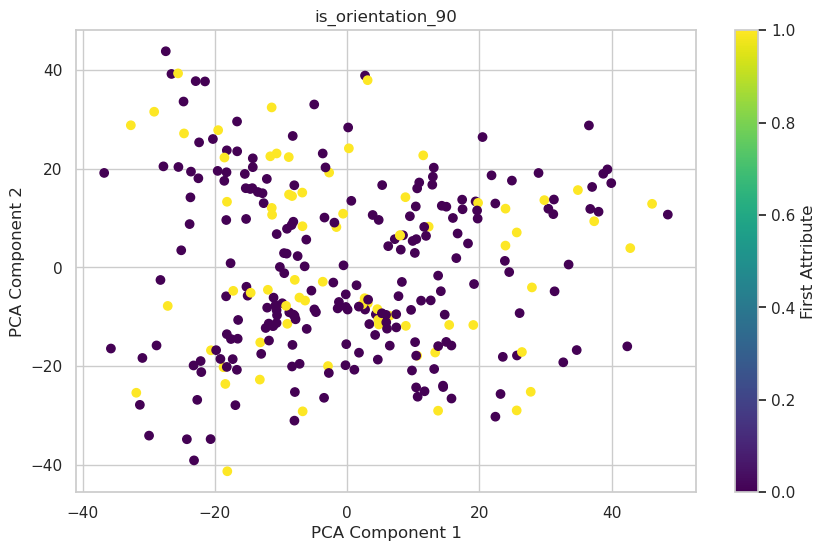

<Figure size 640x480 with 0 Axes>

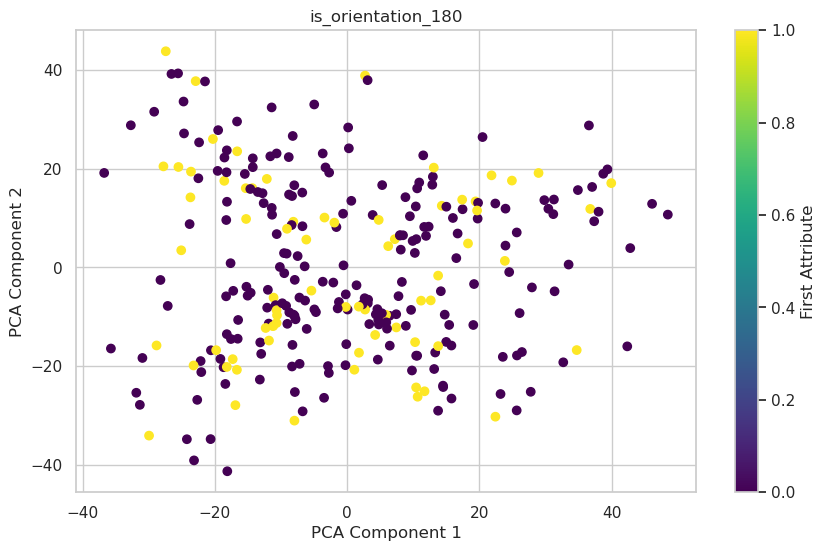

<Figure size 640x480 with 0 Axes>

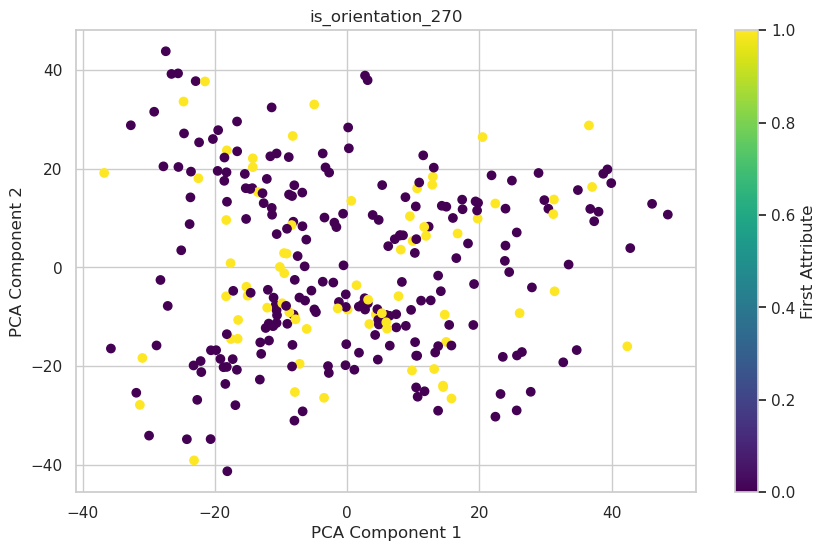

<Figure size 640x480 with 0 Axes>

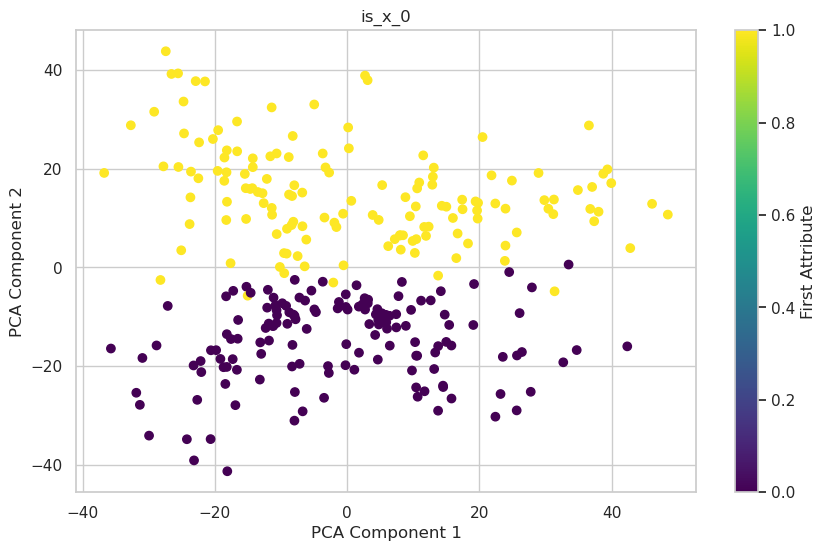

<Figure size 640x480 with 0 Axes>

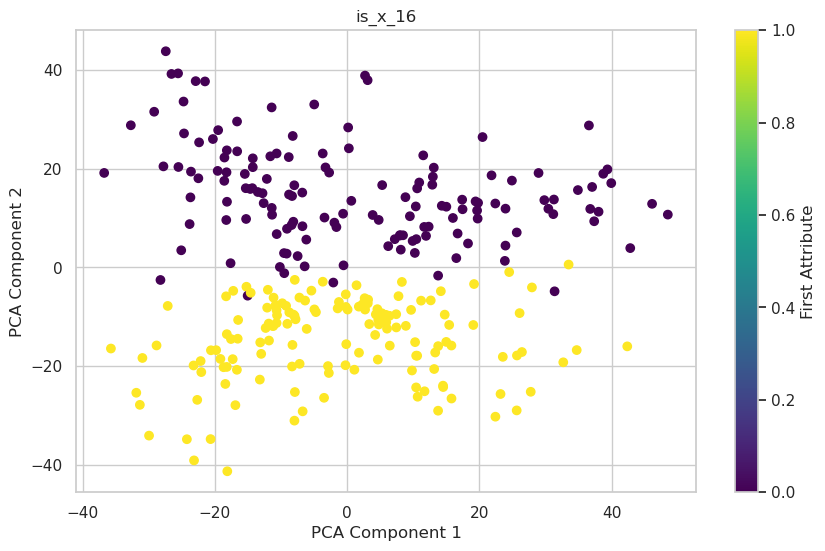

<Figure size 640x480 with 0 Axes>

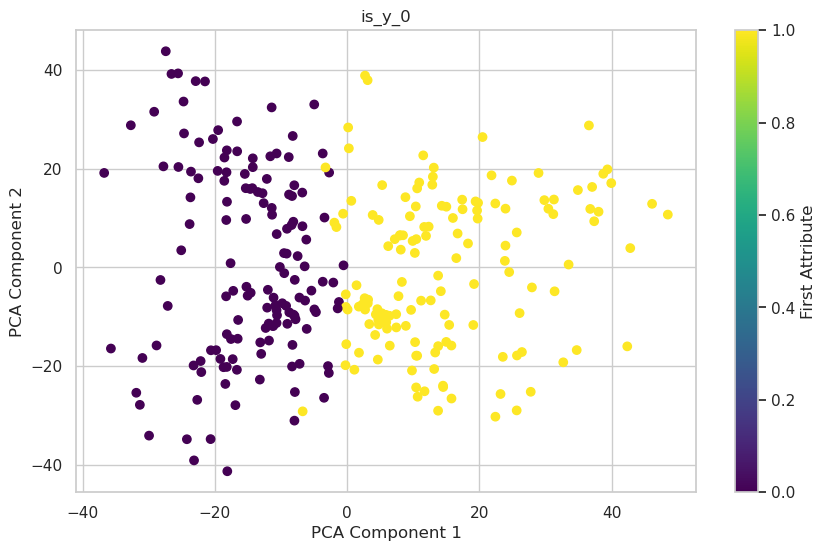

<Figure size 640x480 with 0 Axes>

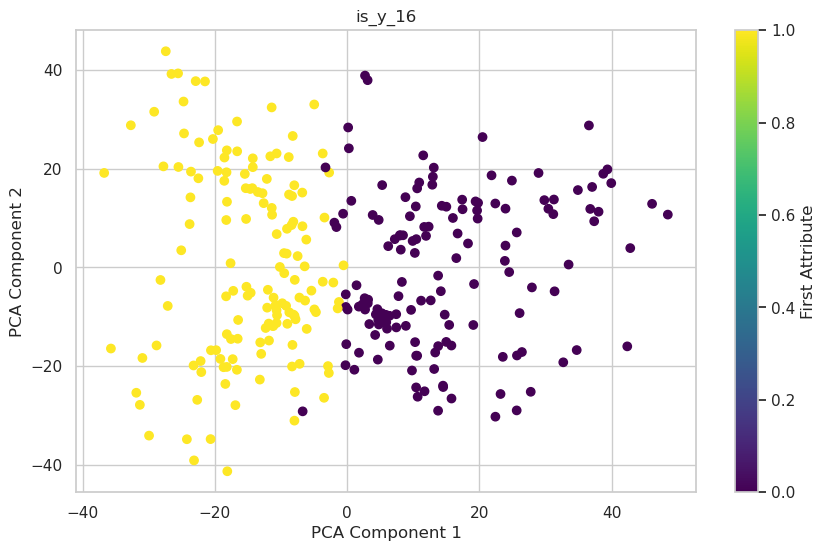

<Figure size 640x480 with 0 Axes>

In [207]:
for i in range(18):
    first_attribute = attributes_as_matrix[:, i]

    # Create a scatter plot and color by the first attribute
    plt.figure(figsize=(10, 6))
    plt.scatter(images_pca[:, 0], images_pca[:, 1], c=first_attribute, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(concept_names[i])
    plt.colorbar(label='First Attribute')
    plt.show()
    plt.figure()


In [209]:
adversarial_rates = {}
for i in results:
    adversarial_rates[i] = results[i]['freq_with_concept_adversarial'][0]/results[i]['freq_with_concept_adversarial'][1]
adversarial_rates

{'is_white': 0.0,
 'is_square': 0.65625,
 'is_ellipse': 0.5729166666666666,
 'is_heart': 0.3541666666666667,
 'is_scale_0.5': 0.9166666666666666,
 'is_scale_0.6': 0.8125,
 'is_scale_0.7': 0.6875,
 'is_scale_0.8': 0.8541666666666666,
 'is_scale_0.9': 0.9375,
 'is_scale_1': 0.25,
 'is_orientation_0': 0.8055555555555556,
 'is_orientation_90': 0.5555555555555556,
 'is_orientation_180': 0.7083333333333334,
 'is_orientation_270': 0.8472222222222222,
 'is_x_0': 0.027777777777777776,
 'is_x_16': 0.013888888888888888,
 'is_y_0': 0.020833333333333332,
 'is_y_16': 0.041666666666666664}